# Contextual Bayesian Optimisation via Large Language Models

This notebook will execute Contextual Bayesian Optimisation, in attempt to detect whether LLMs can learn contextual information.

**NOTE:** Before running this file, you must fix the relative import issues - all you must do is remove the full stop from in front of the imports. Until the directory is cleaned, this has to be done if you want to run the code in the notebook. If you do not, you may run the test files instead.

<DIV STYLE="background-color:#000000; height:10px; width:100%;">

# Import Libraries

In [8]:
# Standard Library
import os
import pickle
import random

# Third Party
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Private
from tenacity import (
    retry,
    stop_after_attempt,
    wait_random_exponential,
)
from ..models import *

ImportError: attempted relative import with no known parent package

In [4]:
import os

os.getcwd()

'/Users/siddarthanath/Documents/University-College-London/Thesis/cebo/notebooks'

In [12]:
# Default OpenAI API Key
os.environ["OPENAI_API_KEY"] = ""

# Data Preparation

The dataset can be found here [BigSOL](https://zenodo.org/record/6809669). We use this for contextual BO as we are provided with varying context, for the same compound and solute. In the original BO setup of BO-LIFT, we want to remove points because there is no context and the goal is to obtain the values of as many new points as possible to find the maximum. In the contextual BO setup, the goal is different - we want to choose the appropriate point for the current context, which can be anything from the pool.

In [3]:
def create_dataset(path, num_occurrences_low, num_occurrences_high, temps, num_smiles):
    data = pd.read_csv(path)
    data = data.dropna()
    data = data.drop_duplicates().reset_index(drop=True)
    data.rename(columns={"T,K": "Temperature"}, inplace=True)
    data = data.sort_values(by="SMILES")
    # Shrink dataset
    main_data = pd.DataFrame(columns=["SMILES"] + list(data["Temperature"].unique()))
    for smile in data["SMILES"].unique():
        sub_result = data[data["SMILES"] == smile]
        sub_temp = {"SMILES": smile}
        sub_temp.update(dict(sub_result["Temperature"].value_counts()))
        for temp in list(main_data.columns):
            if temp not in sub_temp.keys():
                sub_temp[temp] = 0
        main_data = pd.concat(
            (pd.DataFrame([sub_temp], columns=list(main_data.columns)), main_data)
        )
    sub_data = main_data[["SMILES"] + temps]
    mask = (sub_data.iloc[:, 1:] > num_occurrences_low) & (
        sub_data.iloc[:, 1:] < num_occurrences_high
    )
    mask = mask.all(axis=1)
    refined_data = sub_data[mask]
    refined_data = refined_data[refined_data.iloc[:, 1:].eq(5).all(axis=1)]
    refined_data = refined_data[refined_data["SMILES"].apply(lambda x: len(x) < 30)][
        :num_smiles
    ]
    combined_data = data.merge(refined_data["SMILES"], on="SMILES")
    combined_data = combined_data[combined_data["Temperature"].isin(temps)]
    # Final dataframe
    combined_data.rename(columns={"SMILES_Solvent": "SMILES Solvent"}, inplace=True)
    combined_df = combined_data[
        ["SMILES", "Temperature", "SMILES Solvent", "Solubility"]
    ].reset_index(drop=True)
    return combined_df, refined_data

In [4]:
# Create dataset
bigsoldb_df, bigsoldmask_df = create_dataset(
    path="../cebo/data/bigsoldb.csv",
    num_occurrences_low=4,
    num_occurrences_high=6,
    temps=[313.15],
    num_smiles=1,
)

In [5]:
bigsoldb_df.to_csv("bo_vs_cbo.csv", index=False)

In [34]:
# you can write to stdout for debugging purposes, e.g.
# print("this is a debug message")


def solution(A):
    sorted_A_with_indices = sorted(enumerate(A), key=lambda x: x[1], reverse=True)

    # Initialize result array B with zeros
    B = [0] * len(A)

    # Initialize a dictionary to keep track of heights used
    used_heights = {}

    # Assign heights to skyscrapers
    for index, height in sorted_A_with_indices:
        # Find the largest available height not used yet
        current_height = height
        while current_height in used_heights:
            current_height -= 1

        # Assign the height to the skyscraper
        B[index] = current_height

        # Mark this height as used
        used_heights[current_height] = True

    return B, sorted_A_with_indices, used_heights

In [36]:
solution([5, 5, 4, 6, 6])

([4, 3, 2, 6, 5],
 [(3, 6), (4, 6), (0, 5), (1, 5), (2, 4)],
 {6: True, 5: True, 4: True, 3: True, 2: True})

In [6]:
# Calculate maximium value for each unique temperature
def data_max(data):
    max_temp = pd.DataFrame(columns=list(data.columns))
    for i, temp in enumerate(data["Temperature"].unique()):
        sub_result = data[data["Temperature"] == temp].reset_index(drop=True)
        max_index = sub_result["Solubility"].idxmax()
        final_result = sub_result.loc[max_index]
        max_temp.loc[i] = final_result
    return max_temp

In [7]:
bigsoldmask_df

,SMILES,313.15
0,OCC(CO)(CO)CO,5


In [13]:
data_max(bigsoldb_df)

,SMILES,Temperature,SMILES Solvent,Solubility
0,OCC(CO)(CO)CO,313.15,O,0.01535


# ICL Contextual Bayesian Optimisation Experiment

In [57]:
# Helper functions
def combine(s, l):
    """Number of combinations of l elements with max = s"""
    return s**l - (s - 1) ** (l)


def prob(s, l, n):
    """Probability of getting a sample with max([x0,x1,...,xl]) = s where xi={0,n}"""
    return combine(s, l) * ((1 / n) ** l)


def expected_value_p(l, n):
    """Expected value of max([x0,x1,...,xl]) where xi={0,n}"""
    E = [s * prob(s, l, n) for s in range(1, 100 + 1)]
    return sum(E)


def expected_value_q(l, n, data):
    """Expected value of max([x0,x1,...,xl]) where xi={0,n}"""
    quants = [data.quantile(i / 100) for i in range(100 + 1)]
    # E = [(quants[s-1]) * prob(s, l, n) for s in range(1,100+1)]
    E = [((quants[s - 1] + quants[s]) / 2) * prob(s, l, n) for s in range(1, 100 + 1)]
    return sum(E)


def find_target(data, x_start, target):
    matching_index = (data.iloc[:, :-1] == x_start).all(axis=1)
    pos = matching_index[matching_index].index[0]
    y_start = data.loc[pos][target]
    return y_start


def find_experiment(data, result, context, t):
    result_summary = {
        key: value for key, value in result[0][0].items() if key != "Temperature"
    }
    sub_results = data[
        (data[list(result_summary)] == pd.Series(result_summary)).all(axis=1)
    ]
    return data.loc[abs(sub_results[context] - t).idxmin()].to_dict()


def find_target(data, x_start, target):
    matching_index = (data.iloc[:, :-1] == x_start).all(axis=1)
    pos = matching_index[matching_index].index[0]
    y_start = data.loc[pos][target]
    return y_start


def find_experiment(data, result, context, t):
    result_summary = {
        key: value for key, value in result[0][0].items() if key != "Temperature"
    }
    sub_results = data[
        (data[list(result_summary)] == pd.Series(result_summary)).all(axis=1)
    ]
    return data.loc[abs(sub_results[context] - t).idxmin()].to_dict()


def process_frameworks(frameworks, data, target, context=None):
    # Check if context is None and raise ValueError if it's required for C-BO
    if context is None and "C-BO" in frameworks:
        raise ValueError("Context is required for C-BO.")
    # Extract relevant columns from data
    columns = ["SMILES", "SMILES Solvent"]
    # Tell
    for key_1, item_1 in frameworks.items():
        # Check for BO or C-BO
        if key_1 != "BO":
            columns.append(context)
        # Obtain example
        example = data[columns]
        # Tell
        for key_2, item_2 in item_1.items():
            if key_2 != "BO-LIFT":
                example[target] = data[target]
                example_columns = example.to_dict()
                [model.tell(example_columns) for model in item_2]
            else:
                example_columns = list(example)
                [model.tell(example_columns, data[target]) for model in item_2]


def process_optimal_points(frameworks, optimal_points_dict, context, target, selector):
    for key_1, item_1 in frameworks.items():
        for key_2, item_2 in item_1.items():
            for i, model in enumerate(item_2):
                opt_point = optimal_points_dict[key_1][key_2][
                    f"Optimal Point {selector[i % 2]}"
                ][0]
                opt_point_copy = opt_point.copy()
                if key_2 == "BO-LIFT":
                    try:
                        model.tell(
                            [
                                opt_point_copy["SMILES"],
                                opt_point_copy["SMILES Solvent"],
                                opt_point_copy[context],
                            ],
                            opt_point[target],
                        )
                    except BaseException as e:
                        opt_point_copy.pop(target)
                        model.tell(
                            [
                                opt_point_copy["SMILES"],
                                opt_point_copy["SMILES Solvent"],
                            ],
                            opt_point[target],
                        )
                else:
                    pass


def generate_regret_structure(frameworks, f_t_max, y_start, x, results, selector):
    for key_1, item_1 in frameworks.items():
        for key_2, item_2 in item_1.items():
            for i, _ in enumerate(item_2):
                results[key_1][key_2][f"Optimal Point {selector[i % 2]}"].append(
                    {
                        "Regret": f_t_max - y_start,
                        "Parameter": x,
                        "Temperature": x["Temperature"],
                    }
                )


def generate_optimising_point_structure(
    frameworks, pools, aq, methods, strategies, selector
):
    results = {
        strategy: {
            method: {
                f"Optimal Point {selector[0]}": [],
                f"Optimal Point {selector[1]}": [],
            }
            for method in methods
        }
        for strategy in strategies
    }
    for key_1, item_1 in frameworks.items():
        for key_2, item_2 in item_1.items():
            for i, model in enumerate(item_2):
                results[key_1][key_2][f"Optimal Point {selector[i % 2]}"] = model.ask(
                    pools[key_1], aq_fxn=aq, _lambda=1.0
                )
    return results


def process_experiments(data, results, context, t, methods, strategies, selector):
    opt_points_df = []
    opt_points_dict = {
        strategy: {
            method: {
                f"Optimal Point {selector[0]}": [],
                f"Optimal Point {selector[1]}": [],
            }
            for method in methods
        }
        for strategy in strategies
    }
    for method, method_data in results.items():
        # Iterate through the second-level dictionary
        for lift_type, lift_data in method_data.items():
            # Iterate through the 'Optimal Point with MMR' and 'Optimal Point without MMR' entries
            for mmr_type, mmr_data in lift_data.items():
                if len(mmr_data) != 0:
                    opt_points_df.append(find_experiment(data, mmr_data, context, t))
                    opt_points_dict[method][lift_type][mmr_type].append(
                        find_experiment(data, mmr_data, context, t)
                    )
    return pd.DataFrame(opt_points_df), opt_points_dict


def update_regret(current_results, new_results, f_t_max):
    # Update target values
    for method, method_data in current_results.items():
        # Iterate through the second-level dictionary
        for lift_type, lift_data in method_data.items():
            # Iterate through the 'Optimal Point with MMR' and 'Optimal Point without MMR' entries
            for mmr_type, mmr_data in lift_data.items():
                if len(mmr_data) != 0:
                    current_results[method][lift_type][mmr_type].append(
                        {
                            "Regret": f_t_max
                            - new_results[method][lift_type][mmr_type][0]["Solubility"],
                            "Parameter": new_results[method][lift_type][mmr_type][0],
                            "Temperature": new_results[method][lift_type][mmr_type][0][
                                "Temperature"
                            ],
                        }
                    )

In [58]:
@retry(wait=wait_random_exponential(min=1, max=60), stop=stop_after_attempt(6))
def run_experiment_cebo_lift_main(
    frameworks,
    data,
    indexes,
    context,
    target,
    N=10,
    initial_train=1,
    aq="random",
    start_index=0,
):
    # Acquisition function random
    if aq == "random_mean":
        return [(i, expected_value_q(i, 100, data[target])) for i in range(1, N + 1)]
    # Tell
    for i in indexes[:initial_train]:
        process_frameworks(
            frameworks=frameworks, data=data.iloc[i, :], target=target, context=context
        )
    # Create pool
    pools = {
        "BO": [
            data.iloc[i, :][["SMILES", "SMILES Solvent"]].to_dict() for i in indexes
        ],
        "C-BO": [
            data.iloc[i, :][["SMILES", "SMILES Solvent"] + [context]].to_dict()
            for i in indexes
        ],
    }
    # Start point
    x_start = pools["C-BO"][start_index]
    # Obtain function output of start point
    y_start = find_target(data=data, x_start=x_start, target=target)
    x_start_copy = x_start.copy()
    x_start_copy.update({f"{target}": y_start})
    # Tell
    process_frameworks(
        frameworks=frameworks,
        data=pd.Series(x_start_copy),
        target=target,
        context=context,
    )
    # Store regret
    strategies = ["BO", "C-BO"]
    methods = ["BO-LIFT", "CEBO-LIFT"]
    selector = ["with MMR", "without MMR"]
    f_t_max = data[data["Temperature"] == x_start["Temperature"]]["Solubility"].max()
    regret_results = {
        strategy: {
            method: {
                f"Optimal Point {selector[0]}": [],
                f"Optimal Point {selector[1]}": [],
            }
            for method in methods
        }
        for strategy in strategies
    }
    generate_regret_structure(
        frameworks, f_t_max, y_start, x_start_copy, regret_results, selector
    )
    # Initialise Bayesian Optimisation (BO) and Contextual Bayesian Optimisation (C-BO)
    for i in range(1, N):
        # Uniformly sample t ~ T (from pool)
        t = random.choice(data[context].tolist())
        # Remask the temperature of the pool candidates
        for j, ele in enumerate(pools["C-BO"]):
            ele["Temperature"] = t
            pools["C-BO"][j] = ele
        # BO & C-BO - NOTE: remove duplicates in pool when querying!!!
        bo_and_cbo_results = generate_optimising_point_structure(
            frameworks, pools, aq, methods, strategies, selector
        )
        # Match the temperature sampled with the closest temperature in the pool for BO and C-BO
        _, final_opt_points_dict = process_experiments(
            data, bo_and_cbo_results, context, t, methods, strategies, selector
        )
        # Tell
        process_optimal_points(
            frameworks=frameworks,
            optimal_points_dict=final_opt_points_dict,
            context=context,
            target=target,
            selector=selector,
        )
        # Calculate f(x_t^*, t_t)
        f_t_max = data[data[context] == t]["Solubility"].max()
        # Update regret results
        update_regret(regret_results, final_opt_points_dict, f_t_max)
    return regret_results

In [78]:
def run_bo_vs_c_bo(data, num_opt_iterations, num_repeats, num_train, models_list):
    # Create model
    bayesOpts_results = None
    # Loop through models
    for model in models_list:
        # Parameters
        indexes = [i for i in range(data.shape[0])]
        # Store values
        bayesOpts_results = {}
        # Acquisition functions
        aq_fns = ["upper_confidence_bound"]
        for i in range(len(num_train)):
            for j in range(len(aq_fns)):
                print(f"Model = {model} | Acquisition Function = {aq_fns[j]}")
                regret_total_results = []
                for k in range(num_repeats):
                    # Model lists
                    # BO-LIFT with MMR (BO)
                    bo_lift_1 = AskTellFewShotTopk(
                        x_formatter=lambda x: f"SMILES {x[0]}, SMILES Solvent {x[1]}",
                        y_name="solubility",
                        y_formatter=lambda y: f"{y:.6f}",
                        model=model,
                        selector_k=5,
                        temperature=0.7,
                    )
                    # BO-LIFT without MMR (BO)
                    bo_lift_2 = AskTellFewShotTopk(
                        x_formatter=lambda x: f"SMILES {x[0]}, SMILES Solvent {x[1]}",
                        y_name="solubility",
                        y_formatter=lambda y: f"{y:.5f}",
                        model=model,
                        selector_k=5,
                        temperature=0.7,
                    )
                    # CEBO-LIFT with MMR (BO)
                    cebo_lift_1 = CEBO(
                        y_name="solubility",
                        model=model,
                        selector_k=1,
                        temperature=0.7,
                        domain="chemist",
                        features=True,
                    )
                    # CEBO-LIFT without MMR (BO)
                    cebo_lift_2 = CEBO(
                        y_name="solubility",
                        model=model,
                        selector_k=5,
                        temperature=0.7,
                        domain="chemist",
                        features=True,
                    )
                    # BO-LIFT with MMR (C-BO)
                    bo_lift_3 = AskTellFewShotTopk(
                        x_formatter=lambda x: f"SMILES {x[0]}, SMILES Solvent {x[1]} and Temperature {x[2]}",
                        y_name="solubility",
                        y_formatter=lambda y: f"{y:.6f}",
                        model=model,
                        selector_k=5,
                        temperature=0.7,
                    )
                    # BO-LIFT without MMR (C-BO)
                    bo_lift_4 = AskTellFewShotTopk(
                        x_formatter=lambda x: f"SMILES {x[0]}, SMILES Solvent {x[1]} and Temperature {x[2]}",
                        y_name="solubility",
                        y_formatter=lambda y: f"{y:.5f}",
                        model=model,
                        selector_k=5,
                        temperature=0.75,
                    )
                    # CEBO-LIFT with MMR (C-BO)
                    cebo_lift_3 = CEBO(
                        y_name="solubility",
                        model=model,
                        selector_k=1,
                        temperature=0.7,
                        domain="chemist",
                        features=True,
                    )
                    # CEBO-LIFT without MMR (C-BO)
                    cebo_lift_4 = CEBO(
                        y_name="solubility",
                        model=model,
                        selector_k=5,
                        temperature=0.7,
                        domain="chemist",
                        features=True,
                    )
                    framework_types = {
                        "BO": {"BO-LIFT": [bo_lift_1]},
                        "C-BO": {"BO-LIFT": [bo_lift_3]},
                    }
                    starts = np.random.randint(0, len(indexes), num_repeats)
                    regret_results = run_experiment_cebo_lift_main(
                        frameworks=framework_types,
                        data=data,
                        indexes=indexes,
                        context="Temperature",
                        target="Solubility",
                        N=num_opt_iterations,
                        initial_train=num_train[i],
                        aq=aq_fns[j],
                        start_index=starts[k],
                    )
                    regret_total_results.append(regret_results)
                # Store results
                bayesOpts_results[aq_fns[j]] = regret_total_results
    # Specify the file path where you want to save the pickled data
    file_path = "bo_vs_cbo_study.pkl"
    # Pickle and save the data
    with open(file_path, "wb") as file:
        pickle.dump(bayesOpts_results, file)
    print("Contextual Bayesian Optimisation completed!")

# Results

In [79]:
kwargs = {
    "data": bigsoldb_df,
    "models_list": ["curie"],
    "num_opt_iterations": 25,
    "num_repeats": 5,
    "num_train": [5],
}

In [80]:
# NOTE - Sometimes this function runs into API request issues - if so, run this on PyCharm through the test file in debug mode.
run_bo_vs_c_bo(**kwargs)

Model = curie | Acquisition Function = upper_confidence_bound
Contextual Bayesian Optimisation completed!


# Results

In [86]:
with open("bo_vs_cbo_study.pkl", "rb") as file:
    loaded_data = pickle.load(file)

In [87]:
def process_results(results, selector, component):
    df = pd.DataFrame(columns=["Strategy", "Method", "Selection", f"{component}"])
    i = 0
    for method, method_data in results.items():
        # Iterate through the second-level dictionary
        for lift_type, lift_data in method_data.items():
            # Iterate through the 'Optimal Point with MMR' and 'Optimal Point without MMR' entries
            for j, (mmr_type, mmr_data) in enumerate(lift_data.items()):
                component_values = [
                    point[component] for point in results[method][lift_type][mmr_type]
                ]
                if len(component_values) != 0:
                    df.loc[i] = {
                        "Strategy": method,
                        "Method": lift_type,
                        "Selection": selector[i],
                        f"{component}": component_values,
                    }
                    i += 1
    return df

In [88]:
# Obtain simplified results table
results = loaded_data["upper_confidence_bound"]
strategies = ["BO", "C-BO"]
methods = ["BO-LIFT", "CEBO-LIFT"]
selector = ["with MMR", "with MMR"]
component = "Regret"
full_df = pd.DataFrame(columns=["Strategy", "Method", "Selection", f"{component}"])
for result in results:
    df = process_results(results=result, selector=selector, component=component)
    full_df = pd.concat((df, full_df))
full_df = full_df.reset_index(drop=True)
full_grouped = (
    full_df.groupby(["Strategy", "Method", "Selection"])[f"{component}"]
    .apply(list)
    .reset_index()
)

In [89]:
# Function to plot the lists and their average
def plot_regret_lists(ax, regret_lists, label, avg_label):
    # Plot individual regret lists (slightly faded)
    for i, regret_list in enumerate(regret_lists):
        ax.plot(np.cumsum(regret_list), alpha=0.5, label=f"{label}")
    # Calculate the average regret list
    avg_cum_regret = np.array(regret_lists).mean(axis=0).cumsum()
    # Plot the average regret list (bold)
    ax.plot(
        avg_cum_regret, label=avg_label, linewidth=2.5, linestyle="--", color="black"
    )
    # Add labels and legend
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Cumulative Regret")
    ax.set_title("Regret Over Iterations")
    ax.legend()

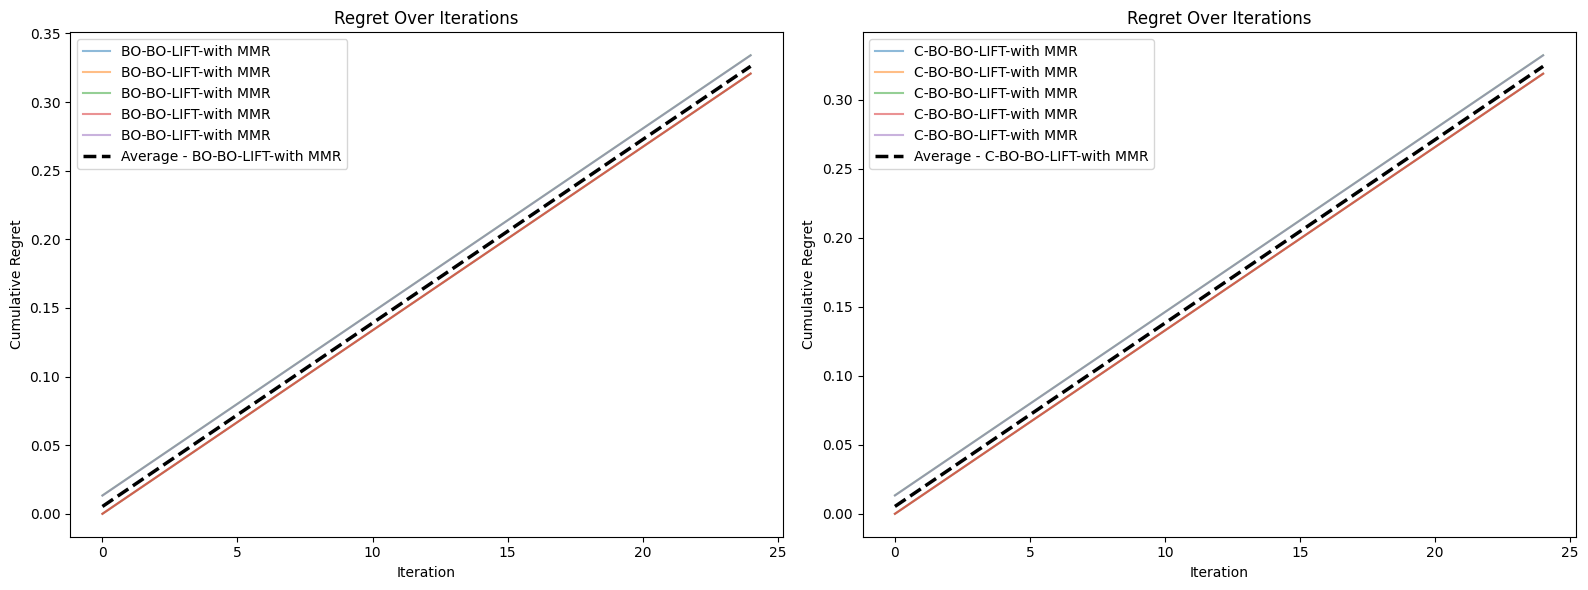

In [90]:
# Create a figure with dynamic number of subplots based on data
num_rows = len(full_grouped)
num_cols = 2  # You can change the number of columns as needed
fig, axs = plt.subplots(
    (num_rows + num_cols - 1) // num_cols, num_cols, figsize=(16, 6)
)
# Iterate through the rows in your data
for i, (_, row) in enumerate(full_grouped.iterrows()):
    strategy = row["Strategy"]
    method = row["Method"]
    selection = row["Selection"]
    regret_lists = row["Regret"]
    label = f"{strategy}-{method}-{selection}"
    avg_label = f"Average - {label}"
    # Plot in the corresponding subplot
    plot_regret_lists(axs[i], regret_lists, label, avg_label)
# Adjust spacing between subplots
plt.tight_layout()
# Show the plot
plt.show()

<DIV STYLE="background-color:#000000; height:10px; width:100%;">